# Feature-Based Knowledge Distillation

![](img/RBKD3.png)

- Distillation Loss = 모델의 중간 층의 출력인 Attention map을 MSE Loss를 통해 비교한 Loss 2개 + student model의 Cross entropy Loss 1개

- Teacher Model(ResNet 18 + SE Block)과 Student Model(CNN with 3 Layers + SE Block)은 사전에 학습을 시킨 후 불러왔음

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
import torch.optim as optim
from torchsummary import summary

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import numpy as np
import time
from IPython.display import clear_output

## Knowledge Distillation을 위한 준비

### Model 정의

In [2]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        
    def forward(self, x):
        b, c, h, w = x.size()
        out = self.pool(x).view(b, c)
        out = F.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out)).view(b, c, 1, 1)
        out = out.expand(b, c, h, w)
        return out
    
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes,kernel_size=3,padding=1, stride = stride, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,padding=1, stride = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.se = SEBlock(planes)

        self.shortcut = nn.Sequential()

        if stride != 1: # stride가 1이 아니면 image shape이 변형됨 # stride가 1이면 그냥 패스
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=3, padding=1,stride= stride, bias = False),
                nn.BatchNorm2d(planes)
                )

    def forward(self, x):
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        output = self.se(output) * output
        # skip connection
        output += self.shortcut(x)
        output = F.relu(output)
        return output


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks - 1) # stride = 1 -> strides = [1,1] # stride = 2 -> strides = [2,1]
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        output = F.relu(self.bn1(self.conv1(x))) # 채널수만 바뀜
        output = self.layer1(output) #
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = F.avg_pool2d(output, 4) # img shape 1/4
        output = output.view(output.size(0), -1) # FC Layer
        output = self.linear(output) # img shape = [batch size, num_classes]
        return output

    def get_features1(self, x):
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.layer1(output)
        output = self.layer2(output)# 16, 16
        output = self.layer3(output)# 8, 8
        output = torch.sum(output,1)
        output = output.view(output.size(0),-1)
        return output

    def get_features2(self, x):
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.layer1(output)
        output = self.layer2(output) # 16,16
        output = self.layer3(output) # 8, 8
        output = self.layer4(output) # 4, 4
        output = torch.sum(output,1)
        output = output.view(output.size(0), -1) # FC Layer
        return output

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

class student_CNN(nn.Module):
    def __init__(self):
        super(student_CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64)
            )
        self.se1 = SEBlock(64)

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64)
            )
        self.se2 = SEBlock(64)

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128)
            )
        self.se3 = SEBlock(128)  

        self.linear = nn.Linear(512, 10)


    def forward(self, x):
        output = F.relu(self.layer1(x))
        output = self.se1(output) * output # 64,16,16 = 16384
        
        output = F.relu(self.layer2(output))
        output = self.se2(output) * output # 64,8,8 = 4096
        
        output = F.relu(self.layer3(output))
        output = self.se3(output) * output # 128,4,4 = 2048

        output = F.avg_pool2d(output, 2)
        
        output = output.view(output.size(0),-1)
        output = self.linear(output)
        return output

    def get_features1(self, x):
        output = F.relu(self.layer1(x)) # 16,16
        output = self.se1(output) * output

        output = F.relu(self.layer2(output))
        output = self.se2(output) * output

        output = torch.sum(output,1)
        output = output.view(output.size(0),-1)
        return output
    
    def get_features2(self, x):
        output = F.relu(self.layer1(x)) # 16,16
        output = self.se1(output)* output

        output = F.relu(self.layer2(output)) # 8,8
        output = self.se2(output) * output

        output = F.relu(self.layer3(output)) # 4,4
        output = self.se3(output) * output
        
        output = torch.sum(output,1)
        output = output.view(output.size(0),-1)
        return output


In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.CIFAR10('./data', train=True, download=True,transform=transform_train)
test_data = datasets.CIFAR10('./data', train=False, download=True,transform=transform_test)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size= 128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size= 100, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### Teacher, Student model 불러오기

In [4]:
T_model = ResNet18()
T_model.load_state_dict(torch.load('teacher_CNN_parm.pth'))

<All keys matched successfully>

In [5]:
S_model = student_CNN()
S_model.load_state_dict(torch.load('student_CNN_parm.pth'))

<All keys matched successfully>

### Teacher, Student model 정확도 확인

In [6]:
T_model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T_model = T_model.to(device)
T_acc = []
with torch.no_grad():
    for batch_idx, (x,y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        yhat = T_model(x)
        y_pred = np.argmax(yhat.detach().to('cpu'), axis=1)
        T_acc.append((y_pred == y.to('cpu')).sum().item() / len(y))
print("Teacher model acc: {:.4f}".format(sum(T_acc)/len(T_acc)))

Teacher model acc: 0.9140


In [7]:
S_model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
S_model = S_model.to(device)
T_acc = []
for batch_idx, (x,y) in enumerate(test_loader):
    x, y = x.to(device), y.to(device)
    yhat = S_model(x)
    y_pred = np.argmax(yhat.detach().to('cpu'), axis=1)
    T_acc.append((y_pred == y.to('cpu')).sum().item() / len(y))
print("student model acc without distillation: {:.4f}".format(sum(T_acc)/len(T_acc)))

student model acc without distillation: 0.7668


## Knowledge Distillation Loss with MSE Loss(attention map)

아래와 같은 실험을 통해 적절한 loss 가중치를 찾음

``` python
T_model.eval()
S_model1.eval()
loss_fn1 = nn.MSELoss()
loss_fn2 = nn.CrossEntropyLoss()
with torch.no_grad():
    for batch_idx, (x, target) in tqdm(enumerate(train_loader)):
        x, target = x.to(device), target.to(device)
        target = F.one_hot(target.to(torch.int64), num_classes = 10)
        
        # attention map 1 loss 계산
        teacher_fm1 = T_model.get_features1(x)
        student_fm1 = S_model1.get_features1(x)
        loss1 = loss_fn1(student_fm1, teacher_fm1)
        
        # attention map 2 loss 계산
        teacher_fm2 = T_model.get_features2(x)
        student_fm2 = S_model1.get_features2(x)

        loss2 = loss_fn1(student_fm2, teacher_fm2)
        
        # Cross entropy loss 계산
        student_pred = S_model1(x)

        loss3 = loss_fn2(student_pred.float(), target.float())

        print(loss1,loss2*0.1,loss3*1000)
        break
```

---

In [12]:
def Distillation_train(T_model, S_model, train_loader, test_loader, epochs, lr = 0.001):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    batch_size = 128

    T_model = T_model.to(device)
    S_model = S_model.to(device)
    optimizr = optim.Adam(S_model.parameters(), lr= lr)
    
    loss_fn1 = nn.MSELoss()
    loss_fn2 = nn.CrossEntropyLoss()

    train_loss = []
    for epch in range(epochs):
        epch += 1

        t_epoch_start = time.time()
        epch_loss = 0.0
        val_epch_loss = 0.0

        # 모델 학습
        T_model.eval()
        S_model.train()

        for batch_idx, (x, target) in tqdm(enumerate(train_loader)):
            x, target = x.to(device), target.to(device)
            target = F.one_hot(target.to(torch.int64), num_classes = 10)

            # attention map 1 loss 계산
            teacher_fm1 = T_model.get_features1(x)
            student_fm1 = S_model.get_features1(x)

            loss1 = loss_fn1(student_fm1, teacher_fm1)
            
            # attention map 2 loss 계산
            teacher_fm2 = T_model.get_features2(x)
            student_fm2 = S_model.get_features2(x)

            loss2 = loss_fn1(student_fm2, teacher_fm2)
            
            # Cross entropy loss 계산
            student_pred = S_model(x)

            loss3 = loss_fn2(student_pred.float(), target.float())

            # loss sum
            loss = loss1 + loss2*0.1 + loss3*10000

            optimizr.zero_grad()

            loss.requires_grad_(True)
            loss.backward()

            optimizr.step()

            epch_loss += loss.item()

        # 모델 검증
        S_model.eval()
        T_acc = []
        with torch.no_grad():
            for batch_idx, (x,y) in enumerate(test_loader):
                x, y = x.to(device), y.to(device)
                yhat = S_model(x)
                y_pred = np.argmax(yhat.detach().to('cpu'), axis=1)
                T_acc.append((y_pred == y.to('cpu')).sum().item() / len(y))

        # 모델 결과 확인
        t_epoch_finish = time.time()
        train_loss.append(epch_loss / batch_size)
        if epch%5==0:
            clear_output(wait = True)
        print('Epoch: {}, Train_Loss: {:4f}, Test acc: {:4f}, Epoch_time: {:.4f}'.format(epch, epch_loss, sum(T_acc)/len(T_acc), t_epoch_finish - t_epoch_start))

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

S_model1 = student_CNN()
Distillation_train(T_model, S_model1, train_loader, test_loader, epochs= 50)

In [14]:
torch.save(obj = S_model1.state_dict(), f= 'student_dist_CNN.pth')

### Distllation model 불러오기 및 성능 확인

In [8]:
S_model1 = student_CNN()
S_model1.load_state_dict(torch.load('student_dist_CNN.pth'))

<All keys matched successfully>

In [9]:
S_model1.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
S_model1 = S_model1.to(device)
T_acc = []
with torch.no_grad():
    for batch_idx, (x,y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        yhat = S_model1(x)
        y_pred = np.argmax(yhat.detach().to('cpu'), axis=1)
        T_acc.append((y_pred == y.to('cpu')).sum().item() / len(y))
print("student model acc with distillation: {:.4f}".format(sum(T_acc)/len(T_acc)))

student model acc with distillation: 0.7768


|Model|Accuracy|Distillation|
|:---:|:---:|:---:|
|Teacher|91.40%|x|
|Student|76.68%|x|
|Student|77.68%|o|

## 학습에 사용된 Attention map 시각화

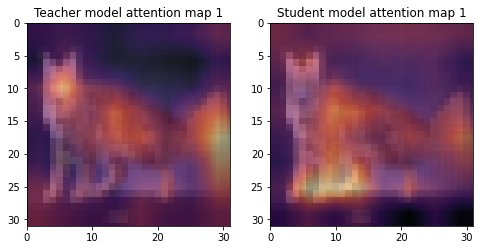

In [ ]:
T_model.to(device)
S_model1.to(device)

T_model.eval()
S_model1.eval()
with torch.no_grad():
    for _, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        fig, ax = plt.subplots(1,2,figsize=(8,4))
        ax[0].imshow(torch.einsum('cij -> ijc',x[0]).to('cpu').detach())
        ax[0].imshow(T_model.get_attention1(x)[0].to('cpu').detach(),cmap='magma',extent=(0,31,31,0),interpolation='bilinear',alpha=0.5)
        ax[0].set_title('Teacher model attention map 1')

        ax[1].imshow(torch.einsum('cij -> ijc',x[0]).to('cpu').detach())
        ax[1].imshow(S_model1.get_attention1(x)[0].to('cpu').detach(),cmap='magma',extent=(0,31,31,0),interpolation='bilinear',alpha=0.5)
        ax[1].set_title('Student model attention map 1')
        break

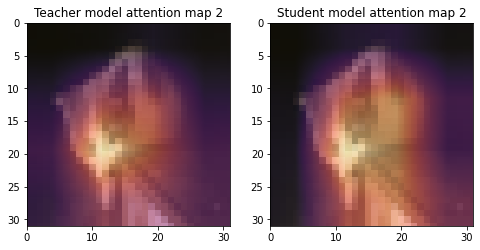

In [ ]:
T_model.to(device)
S_model1.to(device)

T_model.eval()
S_model1.eval()
with torch.no_grad():
    for _, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        fig, ax = plt.subplots(1,2,figsize=(8,4))
        ax[0].imshow(torch.einsum('cij -> ijc',x[0]).to('cpu').detach())
        ax[0].imshow(T_model.get_attention2(x)[0].to('cpu').detach(),cmap='magma',extent=(0,31,31,0),interpolation='bilinear',alpha=0.5)
        ax[0].set_title('Teacher model attention map 2')

        ax[1].imshow(torch.einsum('cij -> ijc',x[0]).to('cpu').detach())
        ax[1].imshow(S_model1.get_attention2(x)[0].to('cpu').detach(),cmap='magma',extent=(0,31,31,0),interpolation='bilinear',alpha=0.5)
        ax[1].set_title('Student model attention map 2')
        break

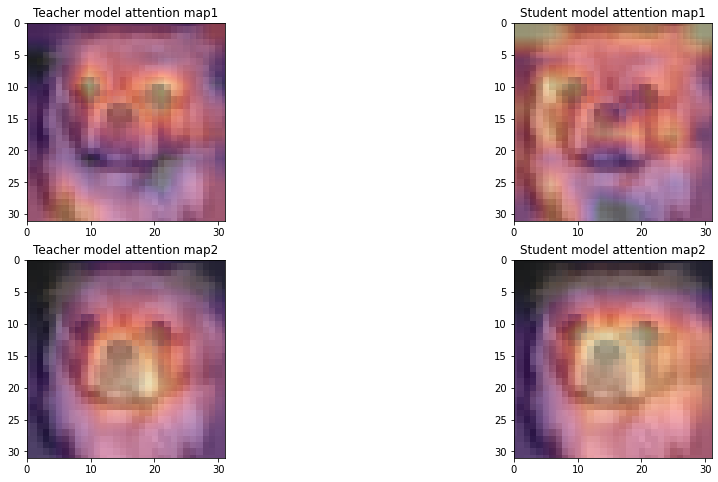

In [ ]:
T_model.to(device)
S_model1.to(device)

T_model.eval()
S_model1.eval()
with torch.no_grad():
    for _, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        fig, ax = plt.subplots(2,2,figsize=(16,8))
        ax[0][0].imshow(torch.einsum('cij -> ijc',x[0]).to('cpu').detach())
        ax[0][0].imshow(T_model.get_attention1(x)[0].to('cpu').detach(),cmap='magma',extent=(0,31,31,0),interpolation='bilinear',alpha=0.5)
        ax[0][0].set_title('Teacher model attention map1')

        ax[0][1].imshow(torch.einsum('cij -> ijc',x[0]).to('cpu').detach())
        ax[0][1].imshow(S_model1.get_attention1(x)[0].to('cpu').detach(),cmap='magma',extent=(0,31,31,0),interpolation='bilinear',alpha=0.5)
        ax[0][1].set_title('Student model attention map1')

        ax[1][0].imshow(torch.einsum('cij -> ijc',x[0]).to('cpu').detach())
        ax[1][0].imshow(T_model.get_attention2(x)[0].to('cpu').detach(),cmap='magma',extent=(0,31,31,0),interpolation='bilinear',alpha=0.5)
        ax[1][0].set_title('Teacher model attention map2')

        ax[1][1].imshow(torch.einsum('cij -> ijc',x[0]).to('cpu').detach())
        ax[1][1].imshow(S_model1.get_attention2(x)[0].to('cpu').detach(),cmap='magma',extent=(0,31,31,0),interpolation='bilinear',alpha=0.5)
        ax[1][1].set_title('Student model attention map2')
        break